# MSADS509 Final Project M7 UE Wang

In [1]:
import datetime
import random
import time
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from collections import defaultdict, Counter

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report

from scipy.sparse import hstack


from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /Users/UE/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/UE/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Load data from desktop MSADS509_News_Project_Dataset folder

In [2]:
df = pd.read_csv('/Users/UE/Desktop/MSADS509_News_Project_Dataset/cleaned.csv')

def clean_tokens(tokens):
    return [token.strip("[]'") for token in tokens.split(', ')]

df['tokens'] = df['tokens'].apply(clean_tokens)

df

,source,url,content,tokens
0,cnn,https://www.cnn.com/2024/02/16/politics/russia...,Russia is trying to develop a nuclear space we...,"[russia, trying, develop, nuclear, space, weap..."
1,cnn,https://www.cnn.com/2024/02/15/politics/takeaw...,The Georgia election subversion case against T...,"[georgia, election, subversion, case, trump, 1..."
2,cnn,https://www.cnn.com/2024/02/16/politics/biden-...,The Norfolk Southern train derailment that sen...,"[norfolk, southern, train, derailment, sent, t..."
3,cnn,https://www.cnn.com/2024/02/16/politics/gaetz-...,The House Ethics Committee investigating Rep. ...,"[house, ethics, committee, investigating, rep,..."
4,cnn,https://www.cnn.com/2024/02/16/politics/takeaw...,Judge Arthur Engoron hit Trump with his bigges...,"[judge, arthur, engoron, hit, trump, biggest, ..."
...,...,...,...,...
235,foxnews,https://www.foxnews.com/politics/senate-foreig...,Fate of foreign aid bill remains uncertain aft...,"[fate, foreign, aid, bill, remains, uncertain,..."
236,foxnews,https://www.foxnews.com/politics/white-house-s...,Biden on release of classified docs report: 'T...,"[biden, release, classified, docs, report, mat..."
237,foxnews,https://www.foxnews.com/politics/house-gop-tes...,Jean-Pierre defends Biden mental fitness and k...,"[jeanpierre, defends, biden, mental, fitness, ..."
238,foxnews,https://www.foxnews.com/politics/biden-garners...,It's very awkward to watch Biden try to engage...,"[awkward, watch, biden, try, engage, tiktok, r..."


## EDA for tokens

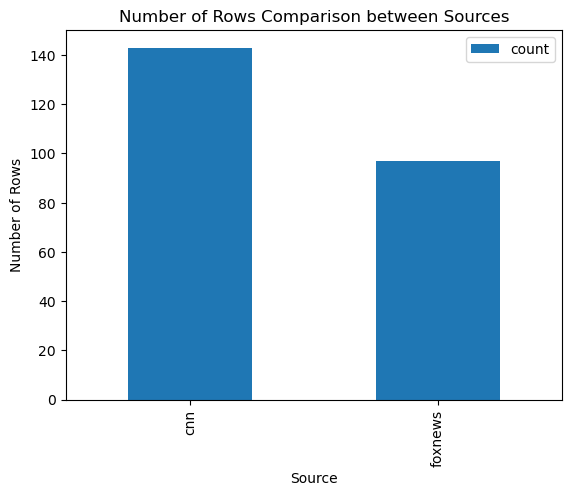

In [3]:
# Count the number of rows for each source
source_counts = df['source'].value_counts()

source_counts.plot(kind='bar', legend=True)
plt.xlabel('Source')
plt.ylabel('Number of Rows')
plt.title('Number of Rows Comparison between Sources')
plt.show()

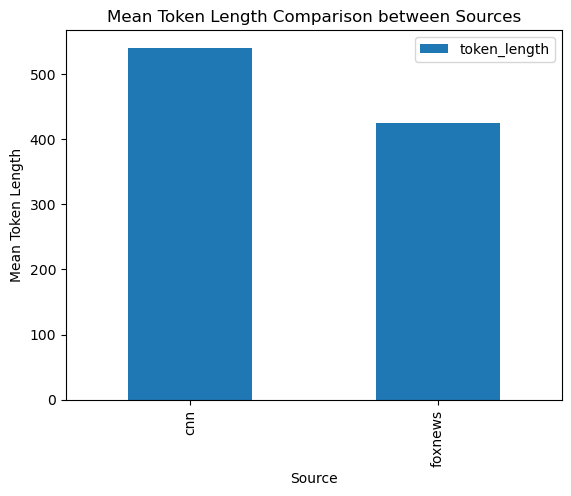

In [4]:
# the length of tokens for each article
df['token_length'] = df['tokens'].apply(lambda x: len(x))

source_token_length = df.groupby('source')['token_length'].mean()

source_token_length.plot(kind='bar', legend=True)
plt.xlabel('Source')
plt.ylabel('Mean Token Length')
plt.title('Mean Token Length Comparison between Sources')
plt.show()

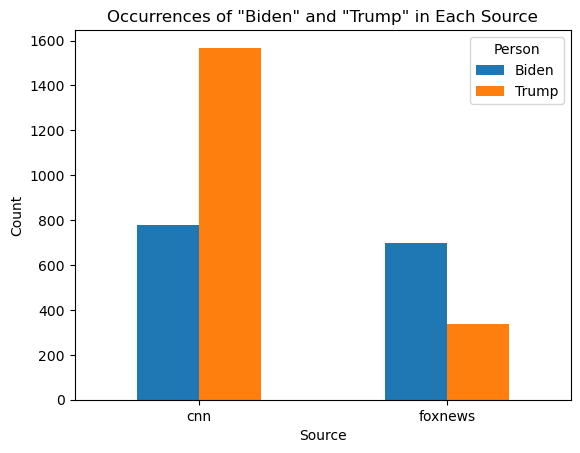

In [5]:
# count occurrences of a word in a list
def count_occurrences(tokens, word):
    return sum(1 for token in tokens if re.search(r'\b{}\b'.format(word), token, flags=re.IGNORECASE))

biden_counts = df.groupby('source')['tokens'].apply(lambda x: sum(count_occurrences(tokens, 'biden') for tokens in x))
trump_counts = df.groupby('source')['tokens'].apply(lambda x: sum(count_occurrences(tokens, 'trump') for tokens in x))

counts_df = pd.DataFrame({'Biden': biden_counts, 'Trump': trump_counts})

counts_df.plot(kind='bar')
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Occurrences of "Biden" and "Trump" in Each Source')
plt.xticks(rotation=0)
plt.legend(title='Person')
plt.show()

## WordCloud for each Source

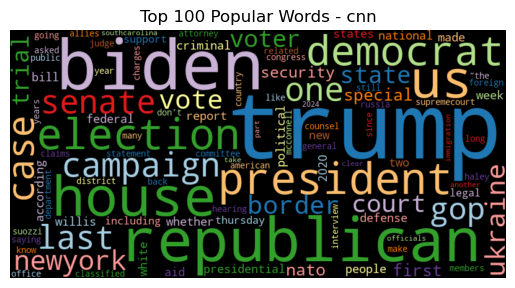

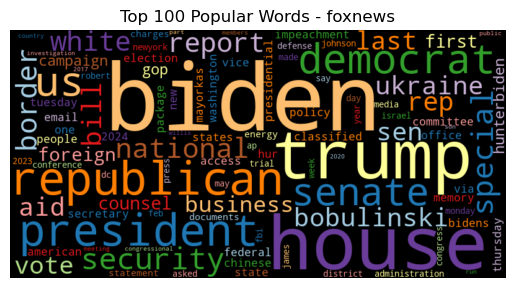

In [6]:

def wordcloud(df, title=None, max_words=100, stopwords=None):
    unique_sources = df['source'].unique()
    for source in unique_sources:
        tokens = df[df['source'] == source]['tokens']
        all_tokens = [token for sublist in tokens for token in sublist]
        counter = Counter(all_tokens)

        # Filter stop words in frequency counter
        if stopwords is not None:
            counter = {token: freq for (token, freq) in counter.items() if token not in stopwords}

        wc = WordCloud(width=800, height=400,
                       background_color="black", colormap="Paired",
                       max_font_size=150, max_words=max_words)
        wc.generate_from_frequencies(counter)
        
        plt.title(f"{title} - {source}")
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()

wordcloud(df, title="Top 100 Popular Words")


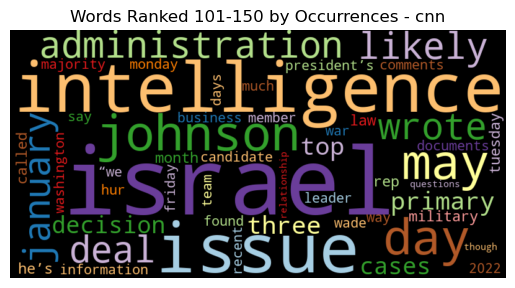

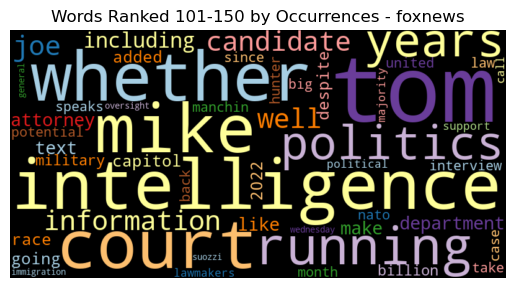

In [7]:

def wordcloud(df, title=None, max_words=200, stopwords=None):
    unique_sources = df['source'].unique()
    for source in unique_sources:
        tokens = df[df['source'] == source]['tokens']
        all_tokens = [token for sublist in tokens for token in sublist]
        counter = Counter(all_tokens)

        # Filter stop words in frequency counter
        if stopwords is not None:
            counter = {token: freq for (token, freq) in counter.items() if token not in stopwords}

        # Sort the counter by frequency and get the words ranked from 101st to 150th
        sorted_counter = dict(counter.most_common())
        words_101_to_150 = dict(list(sorted_counter.items())[100:150])

        wc = WordCloud(width=800, height=400,
                       background_color="black", colormap="Paired",
                       max_font_size=150, max_words=max_words)
        wc.generate_from_frequencies(words_101_to_150)
        
        plt.title(f"{title} - {source}")
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()

wordcloud(df, title="Words Ranked 101-150 by Occurrences")


## Modeling and Model Evaluations

## Sentiment Analysis

In [8]:
sw = stopwords.words("english")
extra_sw = ['cnn', 'fox', 'news', 'said', '–', '-', '--', '—','told', 'would', '…read', 'get', 'could', 
            'also', "it’s", 'think', 'time', 'even', 'former', 'party', 'i', '“i', 'she’s', 'says', 
            'images', 'getty', 'im', 'this', 'we', 'it', 'digital', 'the', 'that', 'story', 'doesn']
sw.extend(extra_sw)

In [9]:
sid = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):

    text_str = ' '.join(text)
    return sid.polarity_scores(text_str)

# get sentiment scores for each news article
df['sentiment_scores'] = df['tokens'].apply(get_sentiment_scores)

# Extract compound sentiment scores (normalized score between -1 (most negative) and +1 (most positive))
df['compound_sentiment'] = df['sentiment_scores'].apply(lambda x: x['compound'])

threshold = 0.05

df['sentiment_label'] = df['compound_sentiment'].apply(lambda score: 'positive' if score > threshold else 'negative' if score < -threshold else 'neutral')

df.head()

,source,url,content,tokens,token_length,sentiment_scores,compound_sentiment,sentiment_label
0,cnn,https://www.cnn.com/2024/02/16/politics/russia...,Russia is trying to develop a nuclear space we...,"[russia, trying, develop, nuclear, space, weap...",513,"{'neg': 0.158, 'neu': 0.695, 'pos': 0.146, 'co...",-0.9150,negative
1,cnn,https://www.cnn.com/2024/02/15/politics/takeaw...,The Georgia election subversion case against T...,"[georgia, election, subversion, case, trump, 1...",849,"{'neg': 0.109, 'neu': 0.8, 'pos': 0.09, 'compo...",-0.9808,negative
2,cnn,https://www.cnn.com/2024/02/16/politics/biden-...,The Norfolk Southern train derailment that sen...,"[norfolk, southern, train, derailment, sent, t...",558,"{'neg': 0.086, 'neu': 0.806, 'pos': 0.107, 'co...",0.8519,positive
3,cnn,https://www.cnn.com/2024/02/16/politics/gaetz-...,The House Ethics Committee investigating Rep. ...,"[house, ethics, committee, investigating, rep,...",97,"{'neg': 0.098, 'neu': 0.807, 'pos': 0.095, 'co...",-0.3400,negative
4,cnn,https://www.cnn.com/2024/02/16/politics/takeaw...,Judge Arthur Engoron hit Trump with his bigges...,"[judge, arthur, engoron, hit, trump, biggest, ...",1124,"{'neg': 0.166, 'neu': 0.761, 'pos': 0.074, 'co...",-0.9990,negative


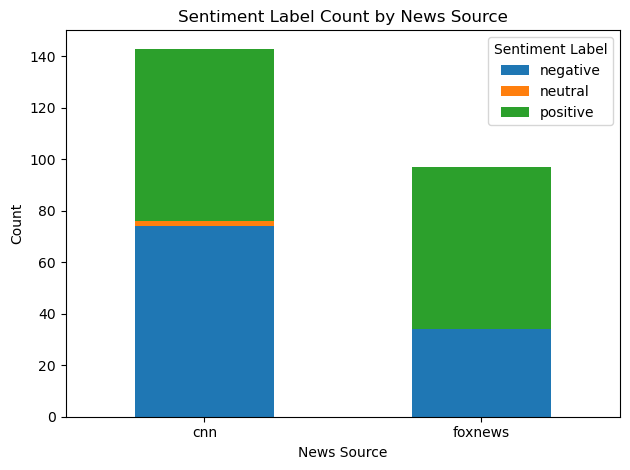

In [10]:
# Group by source and sentiment label and count occurrences
sentiment_counts = df.groupby(['source', 'sentiment_label']).size().unstack(fill_value=0)

sentiment_counts.plot(kind='bar', stacked=True)
plt.title('Sentiment Label Count by News Source')
plt.xlabel('News Source')
plt.ylabel('Count')
plt.xticks(rotation=0)  
plt.legend(title='Sentiment Label')
plt.tight_layout() 
plt.show()

## Binary Classification - Source Prediction

## Predicting News Sources with Random Forest Classifier

In [11]:

# Define X and y
X = df['tokens']  
y = df['source']  

# Convert list of tokens into strings and remove stop words
X_str = X.apply(lambda x: ' '.join([token for token in x if token.lower() not in sw]))

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X_str)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.875
Classification Report:
              precision    recall  f1-score   support

         cnn       0.82      1.00      0.90        28
     foxnews       1.00      0.70      0.82        20

    accuracy                           0.88        48
   macro avg       0.91      0.85      0.86        48
weighted avg       0.90      0.88      0.87        48



In [12]:

feature_importances = model.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

top_n = 20 
print(f"Top {top_n} features and their importances:")
for feature, importance in sorted_feature_importances[:top_n]:
    print(f"Feature: {feature}, Importance: {importance}")

Top 20 features and their importances:
Feature: ap, Importance: 0.018713484289450154
Feature: bidens, Importance: 0.017495849202921878
Feature: via, Importance: 0.01506265352447316
Feature: the, Importance: 0.011041384060773169
Feature: please, Importance: 0.00852284622266109
Feature: 2023, Importance: 0.007564757620968896
Feature: it, Importance: 0.00730522573733351
Feature: that, Importance: 0.005574428064844377
Feature: this, Importance: 0.005544323544347986
Feature: we, Importance: 0.0055406628865644625
Feature: potential, Importance: 0.0053074438490538734
Feature: feb, Importance: 0.005007749230312688
Feature: elkind, Importance: 0.004899083212901747
Feature: cases, Importance: 0.004780905318905588
Feature: 2024, Importance: 0.004694481519430293
Feature: content, Importance: 0.004533215482872805
Feature: policy, Importance: 0.004420101990964651
Feature: finally, Importance: 0.004379428317588008
Feature: correspondent, Importance: 0.004354636600404512
Feature: doesn, Importance: 0.

## Clustering

Top words per cluster for CNN:
Cluster 0: biden, hur, report, president, classified, fbi, house, austin, netanyahu, documents, 
Cluster 1: willis, trump, case, wade, engoron, trial, newyork, judge, attorney, hearing, 
Cluster 2: trump, nato, haley, biden, democrat, suozzi, republican, election, campaign, voter, 
Cluster 3: ukraine, border, aid, bill, senate, republican, house, mcconnell, johnson, vote, 
Cluster 4: trump, supremecourt, court, case, immunity, election, trial, federal, smith, justices, 


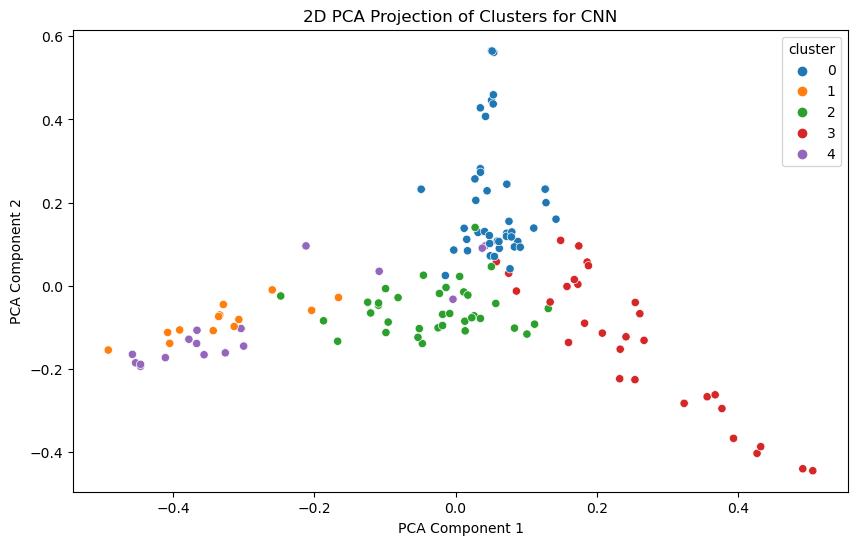

Top words per cluster for FoxNews:
Cluster 0: tiktok, climate, michigan, biden, campaign, cotton, sinema, app, schriver, wray, 
Cluster 1: biden, special, hur, counsel, classified, report, memory, president, documents, robert, 
Cluster 2: house, aid, border, senate, bill, republican, ukraine, package, mayorkas, security, 
Cluster 3: bobulinski, hunterbiden, biden, hunter, business, 2017, fbi, cefc, smirnov, drug, 
Cluster 4: trump, manchin, willis, republican, haley, election, romney, sen, newyork, running, 


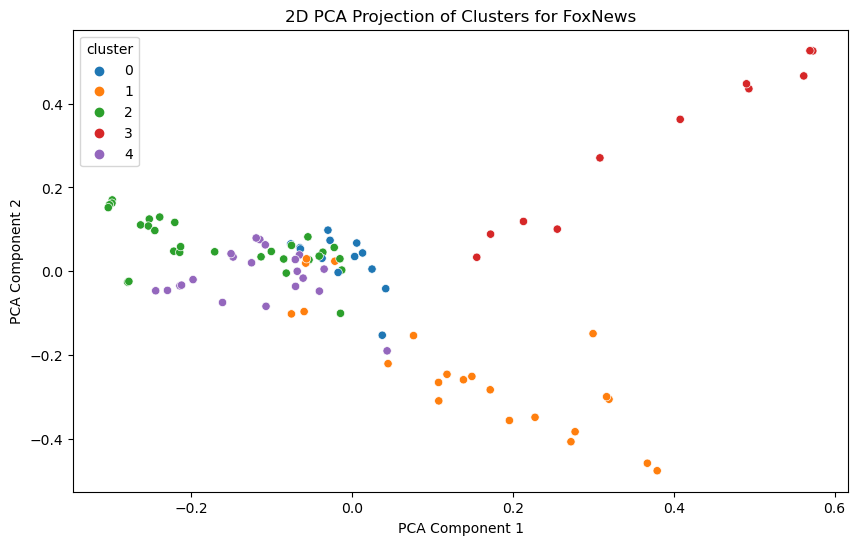

In [13]:

def cluster_and_plot(df, source_name):

    df['text'] = df['tokens'].apply(lambda x: ' '.join(x))
    tfidf_vectorizer = TfidfVectorizer()
    X_tfidf = tfidf_vectorizer.fit_transform(df['text'])

    # K-means clustering
    k = 5
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_tfidf)
    df['cluster'] = clusters

    # Print the top words per cluster
    print(f"Top words per cluster for {source_name}:")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names_out()
    for i in range(k):
        print(f"Cluster {i}: ", end='')
        for ind in order_centroids[i, :10]:
            print(f'{terms[ind]}', end=', ')
        print()

    # Reduce dimensions to 2D using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_tfidf.toarray())

    # Add PCA components to DataFrame
    df['pca1'] = X_pca[:, 0]
    df['pca2'] = X_pca[:, 1]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='tab10', legend='full')
    plt.title(f'2D PCA Projection of Clusters for {source_name}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# CNN articles
df_cnn = df[df['source'] == 'cnn']
cluster_and_plot(df_cnn, 'CNN')

# FoxNews articles
df_fox = df[df['source'] == 'foxnews']
cluster_and_plot(df_fox, 'FoxNews')
